In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import statistics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

## Funciones

Primero especificar si 'simple', derivadas o concatenarlos. Después, hace reducción de dimensionalidad dada una lista de steps, entrena modelos 1-D CNN balanceando los datos (undersampling a la clase con menos muestras + 20%), hace tanto un KFold = 5 entre train/val como un entrenamiento sin KFold. Los datos de test (validación externa) están medidos a parte con muestras diferentes a las de train/val. Se aplica Earlystopping para que corte el entrenamiento cuando en 5 epoch consecutivas la precisión no suba un 1%. 

Entrena los modelos KFold y después entrena un modelo sin KFold para comparar si ha merecido la pena entrenar 5 veces o sale lo mismo, y utiliza este modelo para calcular la importancia de cada feature para la clasificación (o saliencia). La saliencia se obtiene de la siguiente forma: selecciona una feature, sus 4 features vecinas izquierdas y las 4 derechas, las manda a 0 e introduce al modelo entrenado ese espectro modificado, si la región era importante para la clasificación la accuracy caerá, esto se hace para todas las features y se obtiene la importancia de cada feature para la clasificación. 

Finalmente, se representan tres gráficas: el espectro promedio del dataset considerado, la matriz de confusión promedio obtenida a partir del K-fold y la gráfica de saliencia obtenida a partir del modelo entrenado sin K-Fold.

Esto se va a hacer para datasets filtrados con diferentes SNR, y normalizados tanto por espectro como por feature. De esta forma, se obtendrá una comparativa del efecto de filtrar con distintas SNR, de si mejora haciendo la 1a o 2a derivada, y lo mismo normalizando por espectro o feature. Además, se explora si merece la pena usar K-Fold.

In [2]:
import glob
def preprocess_data(ruta_csv, caso):
    filtered_data = pd.read_csv(ruta_csv)

    ##### QUITAR SIGUIENTE LINEA PARA CONSIDERAR CHARCO
    #filtered_data = filtered_data[filtered_data['especie'] != 'charco']

    
    '''#############PARA EJECUTAR RÁPIDO Y VER QUE NO HAYA ERRORES DESCOMENTAR ESTA LÍNEA
    filtered_data = filtered_data.sample(n=500, random_state=42)'''
    
    if caso == 'simple':
        return filtered_data
    
    categorical_columns = ['especie', 'name', 't_exp', 'date', 'medium']
    data_without_especie = filtered_data.drop(columns=categorical_columns)
    
    if caso == '1stderivative':
        first_derivative = data_without_especie.diff(axis=1).iloc[:, 1:-1]
        first_derivative[categorical_columns] = filtered_data[categorical_columns]
        return first_derivative
    
    if caso == '2nderivative':
        first_derivative = data_without_especie.diff(axis=1).iloc[:, 1:-1]
        second_derivative = first_derivative.diff(axis=1).iloc[:, 1:-1]
        second_derivative[categorical_columns] = filtered_data[categorical_columns]
        return second_derivative
    
    if caso == 'concatenate':
        return filtered_data

def main(ruta_csv_trainval, ruta_csv_test, caso, save_path, steps, folder_name, target_column, kfold, saliency):
    # Preprocesar los datos de trainval y test
    filename_trainval = os.path.basename(ruta_csv_trainval)
    norm_type_snr = '_'.join(filename_trainval.split('_')[1:3])  # Guarda la normalización y SNR del archivo

    filtered_data_trainval = preprocess_data(ruta_csv_trainval, caso)
    filtered_data_test = preprocess_data(ruta_csv_test, caso)

    # Listado de columnas categóricas
    categorical_columns = ['X', 'Y', 'especie', 'name', 't_exp', 'date', 'medium']

    # Excluir las columnas categóricas
    data_without_target_trainval = filtered_data_trainval.drop(columns=categorical_columns)
    data_without_target_test = filtered_data_test.drop(columns=categorical_columns)

    ramanshifts = data_without_target_trainval.columns.astype(float)
    #ramanshifts = np.arange(800, 1600, 1)  # Este rango tiene 800 puntos, que es el rango adecuado
    results = []

    for step in steps:
        reduced_columns_trainval = []
        reduced_ramanshifts = []
        num_reduced_columns = len(ramanshifts) // step

        # Crear carpeta para guardar archivos
        folder_path = os.path.join(save_path, folder_name)
        os.makedirs(folder_path, exist_ok=True)


        # Reducir las características promediando columnas dentro del tamaño de paso definido
        for i in range(0, len(ramanshifts), step):
            avg_columns = data_without_target_trainval.iloc[:, i:i+step].mean(axis=1)
            reduced_columns_trainval.append(avg_columns)
            reduced_ramanshifts.append(np.mean(ramanshifts[i:i+step]))

        # Crear un DataFrame con las características reducidas
        filtered_data_reduced_trainval = pd.concat(reduced_columns_trainval, axis=1)
        filtered_data_reduced_trainval.columns = reduced_ramanshifts
        
        # Reducir características en el conjunto de test
        reduced_columns_test = []
        for i in range(0, len(ramanshifts), step):
            avg_columns_test = data_without_target_test.iloc[:, i:i+step].mean(axis=1)
            reduced_columns_test.append(avg_columns_test)
        filtered_data_reduced_test = pd.concat(reduced_columns_test, axis=1)
        filtered_data_reduced_test.columns = reduced_ramanshifts

        if caso == 'concatenate':
            # Calcular y reducir la primera derivada en trainval
            first_derivative_trainval = data_without_target_trainval.diff(axis=1).iloc[:, 1:-1]
            reduced_first_derivative_columns_trainval = []
            reduced_first_derivative_ramanshifts = []
            for i in range(0, len(first_derivative_trainval.columns), step):
                avg_columns = first_derivative_trainval.iloc[:, i:i+step].mean(axis=1)
                reduced_first_derivative_columns_trainval.append(avg_columns)
                reduced_first_derivative_ramanshifts.append(np.mean(ramanshifts[i:i+step]))
            first_derivative_reduced_trainval = pd.concat(reduced_first_derivative_columns_trainval, axis=1)
            first_derivative_reduced_trainval.columns = reduced_first_derivative_ramanshifts

            # Calcular y reducir la segunda derivada en trainval
            second_derivative_trainval = first_derivative_trainval.diff(axis=1).iloc[:, 1:-1]
            reduced_second_derivative_columns_trainval = []
            reduced_second_derivative_ramanshifts = []
            for i in range(0, len(second_derivative_trainval.columns), step):
                avg_columns = second_derivative_trainval.iloc[:, i:i+step].mean(axis=1)
                reduced_second_derivative_columns_trainval.append(avg_columns)
                reduced_second_derivative_ramanshifts.append(np.mean(ramanshifts[i:i+step]))
            second_derivative_reduced_trainval = pd.concat(reduced_second_derivative_columns_trainval, axis=1)
            second_derivative_reduced_trainval.columns = reduced_second_derivative_ramanshifts

            # Concatenar original, primera derivada y segunda derivada en trainval
            filtered_data_reduced_trainval = pd.concat([filtered_data_reduced_trainval, first_derivative_reduced_trainval, second_derivative_reduced_trainval], axis=1)
            reduced_ramanshifts += reduced_first_derivative_ramanshifts + reduced_second_derivative_ramanshifts

            # Hacer lo mismo para el conjunto de test
            first_derivative_test = data_without_target_test.diff(axis=1).iloc[:, 1:-1]
            reduced_first_derivative_columns_test = []
            for i in range(0, len(first_derivative_test.columns), step):
                avg_columns_test = first_derivative_test.iloc[:, i:i+step].mean(axis=1)
                reduced_first_derivative_columns_test.append(avg_columns_test)
            first_derivative_reduced_test = pd.concat(reduced_first_derivative_columns_test, axis=1)
            first_derivative_reduced_test.columns = reduced_first_derivative_ramanshifts

            second_derivative_test = first_derivative_test.diff(axis=1).iloc[:, 1:-1]
            reduced_second_derivative_columns_test = []
            for i in range(0, len(second_derivative_test.columns), step):
                avg_columns_test = second_derivative_test.iloc[:, i:i+step].mean(axis=1)
                reduced_second_derivative_columns_test.append(avg_columns_test)
            second_derivative_reduced_test = pd.concat(reduced_second_derivative_columns_test, axis=1)
            second_derivative_reduced_test.columns = reduced_second_derivative_ramanshifts

            # Concatenar original, primera derivada y segunda derivada en test
            filtered_data_reduced_test = pd.concat([filtered_data_reduced_test, first_derivative_reduced_test, second_derivative_reduced_test], axis=1)

        '''# Asignar la columna objetivo de vuelta al DataFrame reducido
        filtered_data_reduced_trainval[target_column] = filtered_data_trainval[target_column].values
        filtered_data_reduced_test[target_column] = filtered_data_test[target_column].values

        # Balancear el dataset de trainval
        all_classes = filtered_data_reduced_trainval[target_column].unique()
        minority_class_size = filtered_data_reduced_trainval[target_column].value_counts().min()
        target_class_size = int(minority_class_size * 1.2)  # Aumentar el tamaño de la clase minoritaria en un 20%

        balanced_trainval_data = pd.DataFrame()
        for class_name in all_classes:
            class_samples = filtered_data_reduced_trainval[filtered_data_reduced_trainval[target_column] == class_name]
            if class_samples.shape[0] > target_class_size:
                reduced_samples = class_samples.sample(n=target_class_size, random_state=1000)
                balanced_trainval_data = pd.concat([balanced_trainval_data, reduced_samples])
            else:
                balanced_trainval_data = pd.concat([balanced_trainval_data, class_samples])

        # Mostrar el número de muestras por clase en el dataset balanceado
        print(f"Number of spectra per class in the balanced trainval dataset based on {target_column}:")
        print(balanced_trainval_data[target_column].value_counts())

        # Preparar el conjunto de test
        X_test = filtered_data_reduced_test.drop(columns=[target_column])
        y_test = filtered_data_reduced_test[target_column]

        # Definir los nombres de los archivos del modelo aquí
        model_filename_h5 = os.path.join(folder_path, f"model_{norm_type_snr}_{caso}_{num_reduced_columns}features_target{target_column}.h5")
        model_filename_keras = os.path.join(folder_path, f"model_{norm_type_snr}_{caso}_{num_reduced_columns}features_target{target_column}.keras")

        # Crear carpeta para guardar archivos si no existe
        os.makedirs(folder_path, exist_ok=True)

        # Crear el LabelEncoder
        le = LabelEncoder()
        num_classes = len(all_classes)

        # Preparar los datos
        X_train_final = balanced_trainval_data.drop(columns=[target_column])
        y_train_final = balanced_trainval_data[target_column]
        y_train_final_encoded = le.fit_transform(y_train_final)
        y_train_final = tf.keras.utils.to_categorical(y_train_final_encoded, num_classes)

        # Procesar y_test
        y_test_encoded = le.transform(y_test)
        y_test_final = tf.keras.utils.to_categorical(y_test_encoded, num_classes)'''





        # Asignar la columna objetivo de vuelta al DataFrame reducido
        filtered_data_reduced_trainval[target_column] = filtered_data_trainval[target_column].values
        filtered_data_reduced_test[target_column] = filtered_data_test[target_column].values

        # Balancear el dataset de trainval
        print("\nBalanceando el conjunto de trainval...")
        all_classes_trainval = filtered_data_reduced_trainval[target_column].unique()
        minority_class_size_trainval = filtered_data_reduced_trainval[target_column].value_counts().min()
        target_class_size_trainval = int(minority_class_size_trainval * 1.2)  # Aumentar el tamaño de la clase minoritaria en un 20%

        balanced_trainval_data = pd.DataFrame()
        for class_name in all_classes_trainval:
            class_samples = filtered_data_reduced_trainval[filtered_data_reduced_trainval[target_column] == class_name]
            if class_samples.shape[0] > target_class_size_trainval:
                reduced_samples = class_samples.sample(n=target_class_size_trainval, random_state=1000)
                balanced_trainval_data = pd.concat([balanced_trainval_data, reduced_samples])
            else:
                balanced_trainval_data = pd.concat([balanced_trainval_data, class_samples])

        # Mostrar el número de muestras por clase en el dataset balanceado de trainval
        print(f"Número de espectros por clase en el conjunto trainval balanceado basado en {target_column}:")
        print(balanced_trainval_data[target_column].value_counts())

        # Balancear el dataset de test
        print("\nBalanceando el conjunto de test...")
        all_classes_test = filtered_data_reduced_test[target_column].unique()
        minority_class_size_test = filtered_data_reduced_test[target_column].value_counts().min()
        target_class_size_test = int(minority_class_size_test * 1.2)  # Aumentar el tamaño de la clase minoritaria en un 20%

        balanced_test_data = pd.DataFrame()
        for class_name in all_classes_test:
            class_samples_test = filtered_data_reduced_test[filtered_data_reduced_test[target_column] == class_name]
            if class_samples_test.shape[0] > target_class_size_test:
                reduced_samples_test = class_samples_test.sample(n=target_class_size_test, random_state=1000)
                balanced_test_data = pd.concat([balanced_test_data, reduced_samples_test])
            else:
                balanced_test_data = pd.concat([balanced_test_data, class_samples_test])

        # Mostrar el número de muestras por clase en el dataset balanceado de test
        print(f"Número de espectros por clase en el conjunto test balanceado basado en {target_column}:")
        print(balanced_test_data[target_column].value_counts())

        # Preparar el conjunto de test
        X_test = balanced_test_data.drop(columns=[target_column])
        y_test = balanced_test_data[target_column]


        

        # Crear carpeta para guardar archivos si no existe
        os.makedirs(folder_path, exist_ok=True)

        # Definir los nombres de los archivos del modelo
        model_filename_h5 = os.path.join(folder_path, f"model_{norm_type_snr}_{caso}_{num_reduced_columns}features_target{target_column}.h5")
        model_filename_keras = os.path.join(folder_path, f"model_{norm_type_snr}_{caso}_{num_reduced_columns}features_target{target_column}.keras")

        # Crear el LabelEncoder
        le = LabelEncoder()
        num_classes = len(all_classes_trainval)  # Usar las clases del conjunto trainval para definir el número de clases

        # Preparar los datos para entrenamiento
        X_train_final = balanced_trainval_data.drop(columns=[target_column])
        y_train_final = balanced_trainval_data[target_column]
        y_train_final_encoded = le.fit_transform(y_train_final)
        y_train_final = tf.keras.utils.to_categorical(y_train_final_encoded, num_classes)

        # Procesar y_test
        y_test_encoded = le.transform(y_test)
        y_test_final = tf.keras.utils.to_categorical(y_test_encoded, num_classes)


        # Dividir los datos en entrenamiento y validación
        X_train, X_val, y_train, y_val = train_test_split(X_train_final, y_train_final, test_size=0.20, random_state=1000)

        # Definir la forma de entrada para el modelo CNN
        input_shape = (len(X_train.columns), 1)


        # Buscar archivos .h5 en la carpeta especificada
        existing_h5_files = glob.glob(os.path.join(folder_path, "*.h5"))

        # Si existe al menos un archivo .h5, usarlo
        if existing_h5_files:
            print(f"Se encontró un archivo .h5 existente. Cargando el modelo desde {existing_h5_files[0]}")
            model_final = tf.keras.models.load_model(existing_h5_files[0])


 
        else:
            # Si no existe el modelo, ejecutar K-Fold
            if kfold == 'yes':
                all_classes = balanced_trainval_data[target_column].unique()
                num_classes = len(all_classes)

                # Inicializar la matriz de confusión acumulativa vacía
                cm_total = np.zeros((num_classes, num_classes))

                # Para acumular predicciones y etiquetas reales
                y_true_all = []
                y_pred_all = []

                # Para almacenar las métricas de K-Fold
                kfold_metrics = {
                    'val_acc': [],
                    'unseens_acc': []
                }

                # Definir el número de pliegues para K-Fold Cross Validation
                n_splits_kfold = 2

                # Crear el objeto KFold
                kf = KFold(n_splits=n_splits_kfold, shuffle=True, random_state=42)

                for fold, (train_index, val_index) in enumerate(kf.split(balanced_trainval_data)):
                    print(f"Training on fold {fold+1}/{n_splits_kfold}...")

                    # Separar datos de entrenamiento y validación para este pliegue
                    X_train_fold = balanced_trainval_data.iloc[train_index].drop(columns=[target_column])
                    y_train_fold = balanced_trainval_data.iloc[train_index][target_column]
                    X_val_fold = balanced_trainval_data.iloc[val_index].drop(columns=[target_column])
                    y_val_fold = balanced_trainval_data.iloc[val_index][target_column]

                    # Codificar etiquetas y aplicar one-hot encoding
                    le = LabelEncoder()
                    num_classes = len(all_classes)

                    y_train_encoded = le.fit_transform(y_train_fold)
                    y_train_fold = tf.keras.utils.to_categorical(y_train_encoded, num_classes)
                    y_val_encoded = le.transform(y_val_fold)
                    y_val_fold = tf.keras.utils.to_categorical(y_val_encoded, num_classes)
                    y_test_encoded = le.transform(y_test)
                    y_test_fold = tf.keras.utils.to_categorical(y_test_encoded, num_classes)

                    # Definir la forma de entrada para el modelo CNN
                    input_shape = (len(X_train_fold.columns), 1)
                    inputs = tf.keras.layers.Input(shape=input_shape)

                    # Definir la arquitectura del modelo CNN
                    model = tf.keras.models.Sequential([
                        inputs,
                        tf.keras.layers.Conv1D(64, 8, padding='same', activation='relu'),
                        tf.keras.layers.MaxPooling1D(pool_size=(2)),
                        tf.keras.layers.Dropout(0.25),
                        tf.keras.layers.Flatten(),
                        tf.keras.layers.Dense(128, activation='relu'),
                        tf.keras.layers.Dropout(0.2),
                        tf.keras.layers.Dense(num_classes, activation='sigmoid')
                    ])

                    # Compilar el modelo con el optimizador Adam
                    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
                    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'], run_eagerly=True)

                    # Definir criterios de early stopping para evitar el sobreajuste
                    early_stopping = tf.keras.callbacks.EarlyStopping(
                        monitor='val_accuracy',
                        min_delta=0.01,
                        patience=5,
                        restore_best_weights=True
                    )

                    # Entrenar el modelo con early stopping
                    history = model.fit(X_train_fold.to_numpy(), y_train_fold, batch_size=32, epochs=100, verbose=2, 
                                        validation_data=(X_val_fold.to_numpy(), y_val_fold), callbacks=[early_stopping])

                    # Evaluar en el conjunto de test (validación externa)
                    y_pred_test = model.predict(X_test.to_numpy())
                    y_pred_test_int = tf.argmax(y_pred_test, axis=1).numpy()
                    y_test_int = tf.argmax(y_test_fold, axis=1).numpy()

                    # Acumular las predicciones y las etiquetas reales para después calcular la matriz de confusión
                    y_true_all.extend(y_test_int)
                    y_pred_all.extend(y_pred_test_int)

                    # Calcular la matriz de confusión para este pliegue y acumularla
                    cm = confusion_matrix(y_test_int, y_pred_test_int, labels=np.arange(num_classes))
                    cm_total += cm

                    # Almacenar las métricas de este pliegue
                    val_acc = accuracy_score(y_val_fold.argmax(axis=1), model.predict(X_val_fold.to_numpy()).argmax(axis=1))
                    unseens_acc = accuracy_score(y_test_int, y_pred_test_int)

                    kfold_metrics['val_acc'].append(val_acc)
                    kfold_metrics['unseens_acc'].append(unseens_acc)

                    print(f"Fold {fold+1}: val_acc = {val_acc:.4f}, unseens_acc = {unseens_acc:.4f}")

                # Calcular resultados promedio de K-Fold
                avg_val_acc_kfold = np.mean(kfold_metrics['val_acc'])
                avg_unseens_acc_kfold = np.mean(kfold_metrics['unseens_acc'])

                print(f"K-Fold Results: avg_val_acc = {avg_val_acc_kfold:.4f}, avg_unseens_acc = {avg_unseens_acc_kfold:.4f}")

                # Guardar el modelo entrenado tras el K-Fold
                model.save(model_filename_h5)
                print(f"Modelo guardado como {model_filename_h5}")

            else:
                

                ############################################## ENTRENAMIENTOS MULTICHANNEL ##############################################

                # Definir y compilar el modelo
                model_final = tf.keras.models.Sequential([
                    tf.keras.layers.Input(shape=input_shape),
                    tf.keras.layers.Conv1D(64, 8, padding='same', activation='relu'),
                    tf.keras.layers.MaxPooling1D(pool_size=(2)),
                    tf.keras.layers.Dropout(0.25),
                    tf.keras.layers.Flatten(),
                    tf.keras.layers.Dense(128, activation='relu'),
                    tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.Dense(num_classes, activation='sigmoid')
                ])

                optimizer_final = tf.keras.optimizers.Adam(learning_rate=0.00005)
                model_final.compile(loss='binary_crossentropy', optimizer=optimizer_final, metrics=['accuracy'], run_eagerly=True)

                early_stopping = tf.keras.callbacks.EarlyStopping(
                    monitor='val_accuracy',
                    min_delta=0.01,
                    patience=5,
                    restore_best_weights=True
                )

                # Entrenar el modelo
                history_final = model_final.fit(X_train.to_numpy(), y_train, batch_size=32, epochs=100, verbose=2,
                                                validation_data=(X_val.to_numpy(), y_val), callbacks=[early_stopping])

                # Guardar el modelo
                model_final.save(model_filename_h5)
                print(f"Modelo guardado como {model_filename_h5}")

                model_final.save(model_filename_keras)
                print(f"Modelo guardado como {model_filename_keras}")


        # Continuar con la evaluación y el resto del código
        # Evaluar el modelo final en el conjunto de test
        y_pred_final = model_final.predict(X_test.to_numpy())
        y_pred_final_int = tf.argmax(y_pred_final, axis=1).numpy()
        y_test_int = tf.argmax(y_test_final, axis=1).numpy()  # y_test_final está one-hot encoded

        final_test_acc = accuracy_score(y_test_int, y_pred_final_int)

        # Evaluar el modelo final en el conjunto de entrenamiento
        y_pred_train = model_final.predict(X_train_final.to_numpy())
        y_pred_train_int = tf.argmax(y_pred_train, axis=1).numpy()
        y_train_int = tf.argmax(y_train_final, axis=1).numpy()
        final_train_acc = accuracy_score(y_train_int, y_pred_train_int)

        # Evaluar el modelo final en el conjunto de validación
        y_pred_val = model_final.predict(X_val.to_numpy())
        y_pred_val_int = tf.argmax(y_pred_val, axis=1).numpy()
        y_val_int = tf.argmax(y_val, axis=1).numpy()
        final_val_acc = accuracy_score(y_val_int, y_pred_val_int)

        # Calcular la matriz de confusión y las gráficas
        calcular = [{'que': 'train', 'X': X_train_final, 'y': y_train_int},
                    {'que': 'val', 'X': X_val, 'y': y_val_int},
                    {'que': 'test', 'X': X_test, 'y': y_test_int}]

        for idx in range(len(calcular)):
            y_pred = model_final.predict(calcular[idx]['X'].to_numpy())
            y_pred_int = tf.argmax(y_pred, axis=1).numpy()
            y_true_int = calcular[idx]['y']

            accuracy = accuracy_score(y_true_int, y_pred_int)
            print(f"{calcular[idx]['que']} accuracy: {accuracy:1.3f}")

            cm = confusion_matrix(y_true_int, y_pred_int, labels=np.arange(num_classes))
            cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # Normalizar por filas

            fig, ax = plt.subplots(figsize=(8, 6))
            sns_heatmap = sns.heatmap(cm_normalized, annot=False, fmt='.2%', cmap='Blues',
                                    xticklabels=le.inverse_transform(np.arange(num_classes)),
                                    yticklabels=le.inverse_transform(np.arange(num_classes)))

            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    value = cm[i, j]
                    if value != 0 and not np.isnan(cm_normalized[i, j]):
                        text = f"{value} ({cm_normalized[i, j] * 100:.2f}%)"
                        text_color = "white" if cm_normalized[i, j] > 0.5 else "black"
                        plt.annotate(text, (j + 0.5, i + 0.5), ha='center', va='center', color=text_color, fontsize=12)
            ax.set_xlabel('Predicted Label', fontsize=17, labelpad=20)
            ax.set_ylabel('True Label', fontsize=17, labelpad=20)
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)
            cbar = sns_heatmap.collections[0].colorbar
            cbar.ax.tick_params(labelsize=13)
            plt.tight_layout()
            fig.savefig(save_path + "cm_onlycorrected" + ".svg", format="svg", dpi=300)
            fig.savefig(save_path + "cm_onlycorrected" + ".png", format="png", dpi=300)

            plt.show()

        ########## MÉTRICAS
        
        # Calcular las métricas por clase
        class_metrics = []
        for i in range(num_classes):
            tp = cm[i, i]  # Verdaderos Positivos
            fn = cm[i, :].sum() - tp  # Falsos Negativos
            tn = cm.sum() - cm[i, :].sum() - cm[:, i].sum() + tp  # Verdaderos Negativos
            fp = cm[:, i].sum() - tp  # Falsos Positivos

            accuracy_class = (tp + tn) / (tp + tn + fp + fn)
            precision = tp / (tp + fp) if (tp + fp) != 0 else 0  # Manejo de división por cero
            recall = tp / (tp + fn) if (tp + fn) != 0 else 0  # Manejo de división por cero
            specificity = tn / (tn + fp) if (tn + fp) != 0 else 0  # Manejo de división por cero
            f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0  # Manejo de división por cero

            # Crear y_true_class one-hot encoded para la clase actual
            y_true_class = np.zeros((len(y_test_int),))
            y_true_class[y_test_int == i] = 1

            # Puntajes de probabilidad para la clase actual
            y_score_class = y_pred_final[:, i]

            # Calcular AUC
            auc = roc_auc_score(y_true_class, y_score_class)

            class_metrics.append({
                'Class': i,
                'Accuracy': accuracy_class,
                'Precision': precision,
                'Recall': recall,
                'Specificity': specificity,
                'F1-Score': f1_score,
                'AUC': auc
            })

        for metrics in class_metrics:
            print(f"Class {metrics['Class']} - Accuracy: {metrics['Accuracy']:.2f}, "
                  f"Recall: {metrics['Recall']:.2f}, Precision: {metrics['Precision']:.2f}, "
                  f"Specificity: {metrics['Specificity']:.2f}, F1-Score: {metrics['F1-Score']:.2f}, "
                  f"AUC: {metrics['AUC']:.4f}")

        # Convertir las métricas a un DataFrame
        metrics_df = pd.DataFrame(class_metrics)

        # Guardar las métricas por clase en un archivo CSV
        metrics_filename = os.path.join(folder_path, f"class_metrics_{norm_type_snr}_{caso}_{num_reduced_columns}features_target{target_column}.csv")
        metrics_df.to_csv(metrics_filename, index=False)
        print(f"Class metrics saved as {metrics_filename}")



        ##########

        # Comparación de métricas
        if kfold == 'yes':
            print("\nComparison between K-Fold and Final Model:")
            print(f"K-Fold Validation Accuracy (avg): {avg_val_acc_kfold:.4f}")
            print(f"K-Fold Test Accuracy (avg): {avg_unseens_acc_kfold:.4f}")
        print(f"Final Model Test Accuracy: {final_test_acc:.4f}")


        ########################
        # Obtener las etiquetas predichas (clases originales)
        y_pred_labels = le.inverse_transform(y_pred_final_int)

        # Obtener las columnas ['especie', 'name', 't_exp', 'date', 'medium'] del conjunto de test

        # Crear test_metadata sincronizado
        #test_metadata = filtered_data_test[categorical_columns].loc[filtered_data_reduced_test.index]


        # Crear test_metadata sincronizado

        #test_metadata = test_metadata.loc[balanced_test_data.index].reset_index(drop=True)

        test_metadata = filtered_data_test[categorical_columns].loc[balanced_test_data.index].reset_index(drop=True)

        print(f"Dimensiones de test_metadata: {test_metadata.shape}")
        print(f"Dimensiones de y_pred_labels: {len(y_pred_labels)}")
        print(f"Dimensiones de X_test: {X_test.shape}")
        print(f"Dimensiones de balanced_test_data: {balanced_test_data.shape}")


        #test_metadata = filtered_data_test[categorical_columns].reset_index(drop=True)

        # Crear un DataFrame con los metadatos y las predicciones
        test_results = test_metadata.copy()
        test_results['Predicted_Label'] = y_pred_labels

    


        # Guardar el DataFrame en un archivo CSV
        test_results_filename = os.path.join(folder_path, f"test_predictions_{norm_type_snr}_{caso}_{num_reduced_columns}features_target{target_column}.csv")
        test_results.to_csv(test_results_filename, index=False)
        print(f"Test predictions saved as {test_results_filename}")
        ########################


        if saliency == 'yes':
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))
        else:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        # Gráfico 1: espectro promedio con reducción de dimensionalidad
        mean_intensity = balanced_trainval_data.iloc[:, :-1].mean(axis=0)
        reduced_ramanshifts_plot = np.arange(reduced_ramanshifts[0], reduced_ramanshifts[0] + len(reduced_ramanshifts) * (reduced_ramanshifts[1] - reduced_ramanshifts[0]), reduced_ramanshifts[1] - reduced_ramanshifts[0])
        ax1.plot(reduced_ramanshifts_plot, mean_intensity, lw=2.5)
        ax1.legend([f'{len(reduced_ramanshifts)} features'], loc='upper left', fontsize=17)
        ax1.set_xlabel('Raman shift [cm$^{-1}$]', fontsize=19, labelpad=10)
        ax1.set_ylabel('Intensity [a.u]', fontsize=19, labelpad=11)
        ax1.set_xlim([700, 1700])
        ax1.set_xticks(np.arange(700, 1900, 200))
        ax1.set_xticklabels(np.arange(700, 1900, 200), fontsize=16)
        ax1.grid(True, alpha=0.4)
        yticks = ax1.get_yticks()
        yticks_rounded = np.round(yticks, 2)
        ax1.set_yticks(yticks)
        ax1.set_yticklabels(yticks_rounded, fontsize=16)

        # Guardar datos de ax1
        ax1_data = pd.DataFrame({
            'Raman_shift': reduced_ramanshifts_plot,
            'Mean_Intensity': mean_intensity
        })
        ax1_data_filename = os.path.join(folder_path, f"meanspectrum_{norm_type_snr}_{caso}_{num_reduced_columns}features_target{target_column}.csv")
        ax1_data.to_csv(ax1_data_filename, index=False)
        print(f"Mean spectrum saved as {ax1_data_filename}")

        # Gráfico 2: Matriz de confusión normalizada
        cm = confusion_matrix(y_test_int, y_pred_final_int, labels=np.arange(num_classes))
        cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

        # Plot the confusion matrix heatmap
        sns_heatmap = sns.heatmap(cm_normalized, annot=False, fmt='.2%', cmap='Blues', 
                                xticklabels=le.inverse_transform(np.arange(num_classes)), 
                                yticklabels=le.inverse_transform(np.arange(num_classes)), ax=ax2)

        # Crear un DataFrame para almacenar el texto formateado
        ax2_data_text = pd.DataFrame(index=le.inverse_transform(np.arange(num_classes)),
                                    columns=le.inverse_transform(np.arange(num_classes)))

        # Añadir anotaciones a cada celda del heatmap y rellenar el DataFrame con los textos formateados
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                value = cm[i, j]
                if value != 0 and not np.isnan(cm_normalized[i, j]):
                    text = f"{value} ({cm_normalized[i, j] * 100:.2f}%)"
                    text_color = "white" if cm_normalized[i, j] > 0.5 else "black"
                    ax2.annotate(text, (j + 0.5, i + 0.5), ha='center', va='center', color=text_color, fontsize=15)
                    # Almacenar el texto formateado en el DataFrame
                    ax2_data_text.iloc[i, j] = text
                else:
                    ax2_data_text.iloc[i, j] = ""  # Si el valor es 0 o NaN, dejar la celda vacía

        ax2.set_xlabel('Predicted Label', fontsize=18, labelpad=10)
        ax2.set_ylabel('True Label', fontsize=18, labelpad=10)
        ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=16)
        ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=16)
        cbar = ax2.collections[0].colorbar
        cbar.ax.tick_params(labelsize=13)

        # Guardar datos de la matriz de confusión 
        cm_data_filename = os.path.join(folder_path, f"cm_data_{norm_type_snr}_{caso}_{num_reduced_columns}_target{target_column}.csv")
        ax2_data_text.to_csv(cm_data_filename, index=True)
        print(f"Confusion matrix data saved as {cm_data_filename}")

        # Gráfico 3: Saliencia (si corresponde)
        if saliency == 'yes':
            original_output_final = model_final.predict(X_test.to_numpy())
            output_diff_data = []

            total_iterations = len(reduced_ramanshifts)
            for idx in range(total_iterations):
                if idx < 4:
                    selected_indices = list(range(idx, idx + 5))
                elif idx > total_iterations - 5:
                    selected_indices = list(range(idx - 4, idx + 1))
                else:
                    selected_indices = list(range(idx - 4, idx + 5))
                modified_test_data = X_test.copy()
                column_means = X_test.mean(axis=0, numeric_only=True)
                min_mean = column_means.min()
                modified_test_data.iloc[:, selected_indices] = min_mean
                modified_probabilities = model_final.predict(modified_test_data.values)
                output_difference = np.abs(modified_probabilities - original_output_final)
                output_difference_mean = np.mean(output_difference, axis=0)
                output_diff_data.append({'feature': X_test.columns[idx], 'output_difference': output_difference_mean})

            output_diff_df = pd.DataFrame(output_diff_data)
            output_diff_df['feature'] = pd.to_numeric(output_diff_df['feature'])
            output_diff_df['average_output_difference'] = output_diff_df['output_difference'].apply(lambda x: sum(x) / len(x))

            # Generar gráfico de saliencia
            ax3.plot(reduced_ramanshifts, output_diff_df['average_output_difference'], color='black', lw=2.5, alpha=0.7)
            ax3.set_xlabel('Raman shift [cm$^{-1}$]', fontsize=19, labelpad=10)
            ax3.set_ylabel('Output Difference', fontsize=19, labelpad=11)
            ax3.set_xlim([700, 1700])
            ax3.set_xticks(np.arange(700, 1900, 200))
            ax3.set_xticklabels(np.arange(700, 1900, 200), fontsize=16)
            ax3.grid(True, alpha=0.4)

            # Guardar datos de saliencia
            ax3_data = pd.DataFrame({
                'Raman_shift': reduced_ramanshifts,
                'Output_Difference': output_diff_df['average_output_difference']
            })
            ax3_data_filename = os.path.join(folder_path, f"saliency_{norm_type_snr}_{caso}_{num_reduced_columns}_target{target_column}.csv")
            ax3_data.to_csv(ax3_data_filename, index=False)
            print(f"Saliency data saved as {ax3_data_filename}")

        # Mostrar y guardar todas las figuras juntas
        plt.tight_layout()
        plt.show()

        # Guardar resultados en el DataFrame final
        results.append({
            'step': step,
            'Nfeatures': len(reduced_ramanshifts),
            'avg_val_acc_kfold': avg_val_acc_kfold if kfold == 'yes' else None,
            'avg_unseens_acc_kfold': avg_unseens_acc_kfold if kfold == 'yes' else None,
            'final_test_acc': final_test_acc
        })

    # Guardar los resultados en un archivo CSV
    resultados_df = pd.DataFrame(results)
    resultados_filename = os.path.join(folder_path, f"results_{norm_type_snr}_{caso}_{num_reduced_columns}features_target{target_column}.csv")
    resultados_df.to_csv(resultados_filename, index=False)
    print(resultados_df)
    print(f"Results saved as {resultados_filename}")


    # Retornar el DataFrame final con los resultados
    return resultados_df


In [5]:
def ejecutar_main(norm, SNR, steps, ruta_save, folder_name, target_column = 'especie', kfold='no', saliency='no'):
    # Definir las rutas para trainval y test
    base_path = "C:\\Users\\fmantecam\\OneDrive - UNICAN\\RamanNanoBase\\FITOPLANCTON_ESPECIES_UAM\\TFMjorge\\df_filtrados\\"
    ruta_trainval = base_path + "species_CORRECTED_normSPECTRUM_SNR30_V271124_FILTRADOPLASTICO2percent_withCOORDINATES_WITHOUTOUTLIERS_kmeans_percentile_281124.csv"
    ruta_test =   base_path + "especiesUAM_UNSEENS_CORRECTED_normSPECTRUM_SNR30_V171124_FILTRADOPLASTICO2percent_withCOORDINATES_WITHOUTOUTLIERS_percentile_281124.csv"

    
    # Llamadas a la función main con diferentes casos
    resultados_normal = main(ruta_trainval, ruta_test, 'simple', ruta_save, steps,folder_name, target_column=target_column, kfold=kfold, saliency=saliency)
    '''resultados_1aderivada = main(ruta_trainval, ruta_test, '1stderivative', ruta_save, steps,folder_name, target_column=target_column, kfold=kfold, saliency=saliency)
    resultados_2aderivada = main(ruta_trainval, ruta_test, '2nderivative', ruta_save, steps, folder_name, target_column=target_column,  kfold=kfold, saliency=saliency)'''

    # Imprimir los resultados
    print(f"Resultados para el caso 'normal' NORM_{norm} con SNR>{SNR}:")
    print(resultados_normal)
    '''print(f"Resultados para el caso '1aderivada' NORM_{norm} con SNR>{SNR}:")
    print(resultados_1aderivada)
    print(f"Resultados para el caso '2aderivada' NORM_{norm} con SNR>{SNR}:")
    print(resultados_2aderivada)'''


In [4]:
user = 'fmantecam'

In [ ]:
ejecutar_main('SPECTRUM', SNR = 30, steps = [1], ruta_save = f'C:\\Users\\{user}\\OneDrive - UNICAN\\RamanNanoBase\\FITOPLANCTON_ESPECIES_UAM\\TFMjorge\\entrenamientos_280824\\', folder_name = 'CORRECTED_021224_20')
#ejecutar_main('FEATURE', SNR = 30, steps = [1], ruta_save = f'C:\\Users\\{user}\\OneDrive - UNICAN\\RamanNanoBase\\FITOPLANCTON_ESPECIES_UAM\\TFMjorge\\entrenamientos_280824\\')


Balanceando el conjunto de trainval...
Número de espectros por clase en el conjunto trainval balanceado basado en especie:
especie
UAM502    9967
UAM588    9967
UAM565    8690
UAM253    8306
Name: count, dtype: int64

Balanceando el conjunto de test...
Número de espectros por clase en el conjunto test balanceado basado en especie:
especie
UAM588    1010
UAM565    1010
UAM253    1010
UAM502     842
Name: count, dtype: int64


Se encontró un archivo .h5 existente. Cargando el modelo desde C:\Users\fmantecam\OneDrive - UNICAN\RamanNanoBase\FITOPLANCTON_ESPECIES_UAM\TFMjorge\entrenamientos_280824\CORRECTED_021224_19\model_CORRECTED_normSPECTRUM_simple_641features_targetespecie.h5
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1155/1155 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1155/1155 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
train accuracy: 0.818


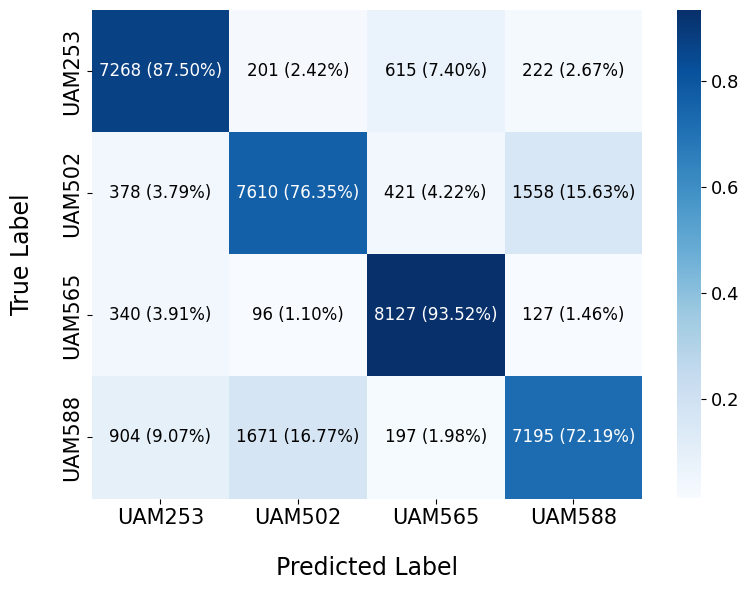

231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
val accuracy: 0.817


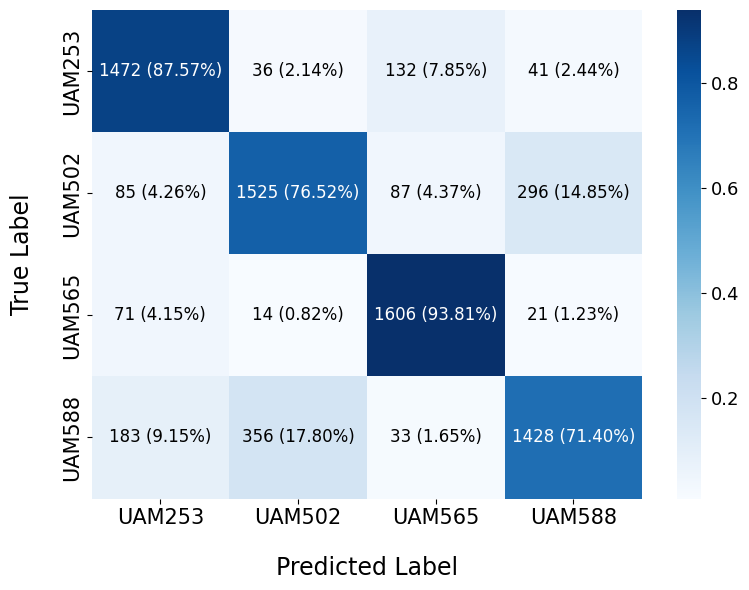

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
test accuracy: 0.735


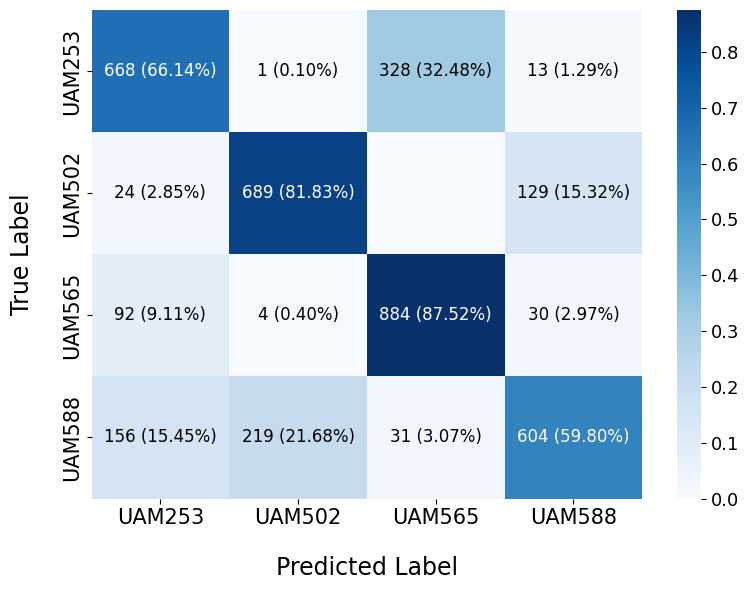

Class 0 - Accuracy: 0.84, Recall: 0.66, Precision: 0.71, Specificity: 0.90, F1-Score: 0.69, AUC: 0.9053
Class 1 - Accuracy: 0.90, Recall: 0.82, Precision: 0.75, Specificity: 0.93, F1-Score: 0.79, AUC: 0.9611
Class 2 - Accuracy: 0.87, Recall: 0.88, Precision: 0.71, Specificity: 0.87, F1-Score: 0.78, AUC: 0.9549
Class 3 - Accuracy: 0.85, Recall: 0.60, Precision: 0.78, Specificity: 0.94, F1-Score: 0.68, AUC: 0.9073
Class metrics saved as C:\Users\fmantecam\OneDrive - UNICAN\RamanNanoBase\FITOPLANCTON_ESPECIES_UAM\TFMjorge\entrenamientos_280824\CORRECTED_021224_19\class_metrics_CORRECTED_normSPECTRUM_simple_641features_targetespecie.csv
Final Model Test Accuracy: 0.7348
Dimensiones de test_metadata: (3872, 7)
Dimensiones de y_pred_labels: 3872
Dimensiones de X_test: (3872, 641)
Dimensiones de balanced_test_data: (3872, 642)
Test predictions saved as C:\Users\fmantecam\OneDrive - UNICAN\RamanNanoBase\FITOPLANCTON_ESPECIES_UAM\TFMjorge\entrenamientos_280824\CORRECTED_021224_19\test_predictio

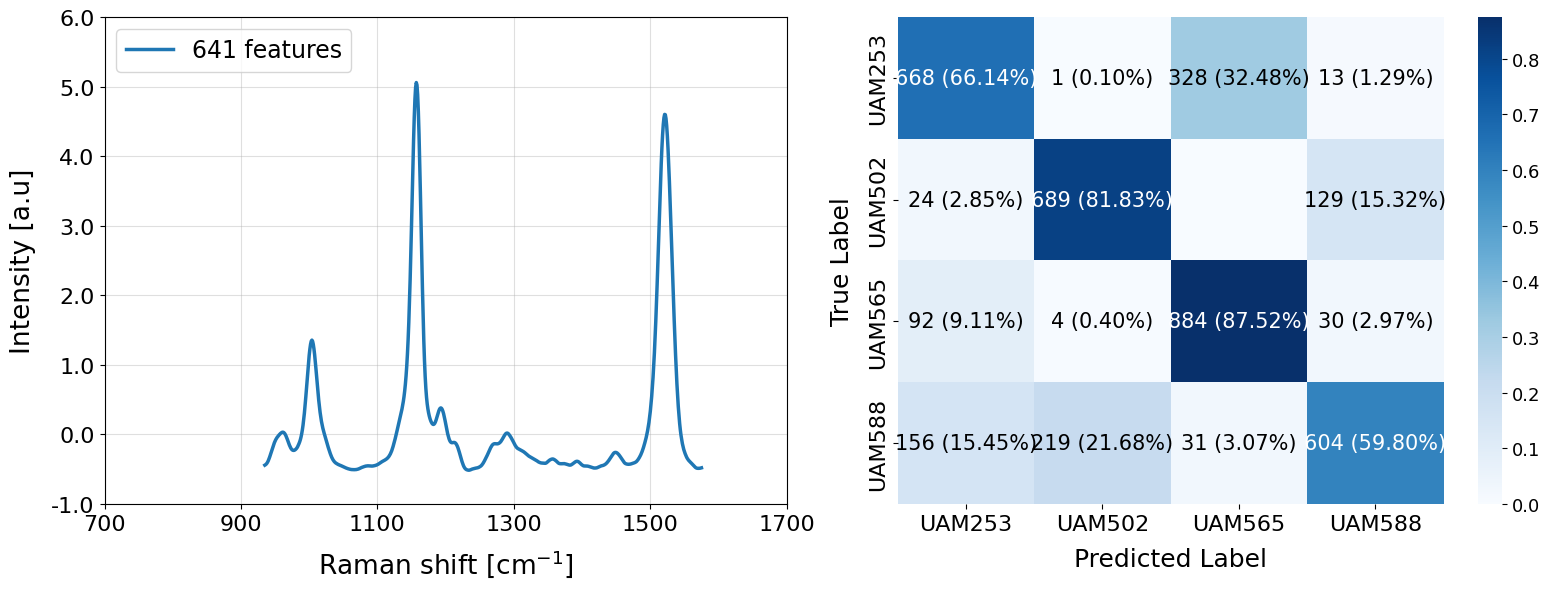

   step  Nfeatures avg_val_acc_kfold avg_unseens_acc_kfold  final_test_acc
0     1        641              None                  None        0.734762
Results saved as C:\Users\fmantecam\OneDrive - UNICAN\RamanNanoBase\FITOPLANCTON_ESPECIES_UAM\TFMjorge\entrenamientos_280824\CORRECTED_021224_19\results_CORRECTED_normSPECTRUM_simple_641features_targetespecie.csv
Resultados para el caso 'normal' NORM_SPECTRUM con SNR>30:
   step  Nfeatures avg_val_acc_kfold avg_unseens_acc_kfold  final_test_acc
0     1        641              None                  None        0.734762


In [8]:
folder_name = f'CORRECTED_021224_19'  # Actualiza dinámicamente el nombre de la carpeta
ruta_save = f'C:\\Users\\{user}\\OneDrive - UNICAN\\RamanNanoBase\\FITOPLANCTON_ESPECIES_UAM\\TFMjorge\\entrenamientos_280824\\'
ejecutar_main('SPECTRUM', SNR=30, steps=[1], ruta_save=ruta_save, folder_name=folder_name)
